In [1]:
# Generate Points Coordinates

import csv, math
import numpy as np

class Plane:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

class Line:
    def __init__(self,x,y,z,e):
        self.x = x
        self.y = y
        self.z = z
        self.e = e

time_stamp = []
distance = []
with open('obs.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count != 0:
            time_stamp.append(row[0])
            distance.append(row[1])
        line_count+=1
time_stamp.reverse()
distance.reverse()

angle = 36*math.pi/180
points = []
start_point = 5
v = np.array([0, math.cos(25*math.pi/180), math.sin(25*math.pi/180)])
A = np.array([[math.cos(angle), 0, math.sin(angle)],[0,1,0],[-math.sin(angle), 0, math.cos(angle)]])
probe_coord = []
while start_point > -5:
    probe_coord.append([0, -1, start_point])
    start_point -= 0.5
    # if len(distance) > 0:
    dis = distance.pop()
    x = probe_coord[-1][0] + (v[0]*float(dis))
    y = probe_coord[-1][1] + (v[1]*float(dis))
    z = probe_coord[-1][2] + (v[2]*float(dis))
    points.append([x,y,z])
    print("[{}, {}, {}]".format(x,y,z))
    v = A.dot(np.array(v))

[0.0, 1.936437229998746, 6.369283168039866]
[1.5475867093721334, 4.64629751323833, 6.630070367141281]
[1.8328183639062328, 3.1327635088871233, 4.595518786050506]
[1.5112712825191745, 2.4077172792578034, 3.008958193958355]
[1.6444661341963922, 4.999757550182623, 0.7365865440649633]
[9.377692939837038e-17, 2.3080234226837724, 0.957443344646447]
[-1.4358027576518348, 4.238459009071837, 0.023787043005360387]
[-2.9100010865528785, 5.561668378145345, 0.5544833309198113]
[-2.5924733436831584, 4.845685226386392, 1.842345651321439]
[-1.679243363620485, 5.126640640367754, 2.8112802057584365]
[-1.3154462425196064e-16, 3.640295869627648, 2.1638055001123813]
[0.9340170188184945, 2.4077172792578034, 0.7855641381141598]
[2.371409725229556, 4.347215943516235, -0.2294822724346528]
[2.548260619992438, 4.74599136981236, -2.3279800665702206]
[1.1352281319150321, 3.1418265867574906, -3.562507476378115]
[1.7136770385948779e-16, 5.045072939534455, -5.318863805810466]
[-1.4631277236279077, 4.338152865645868, 

In [2]:
# Plane Fitting

A = np.matrix([[i[0], i[1], 1] for i in points])
B = np.matrix([[i[2]] for i in points])
param = (A.T * A).I * A.T *B; param

matrix([[ 0.47095722],
        [-0.16088321],
        [ 0.80616294]])

In [3]:
# 3D Projection onto the Plane

a = float(param[0])
b = float(param[1])
c = float(param[2])

# get a point on the plane
# ref_point = [0, 0, c]

proj_points = []
for point in points:
    t = (a * (- point[0]) + b * (- point[1]) + (-1) * (c - point[2])) / (param[0] * param[0] + param[1] * param[1] + 1)
    proj_points.append([point[0] + t * a, point[1] + t * b, point[2] - t])


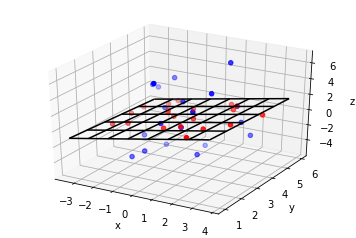

In [5]:
# Plot Plane

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

xs = []
ys = []
zs = []
for i in points:
    xs.append(i[0])
    ys.append(i[1])
    zs.append(i[2])

xp = []
yp = []
zp = []
for i in proj_points:
    xp.append(i[0])
    yp.append(i[1])
    zp.append(i[2])

# plot raw data
plt.figure()
ax = plt.subplot(111, projection='3d')
ax.scatter(xs, ys, zs, color='b')
ax.scatter(xp, yp, zp, color='r')

# plot plane
xlim = ax.get_xlim()
ylim = ax.get_ylim()
X,Y = np.meshgrid(np.arange(xlim[0], xlim[1]),
                  np.arange(ylim[0], ylim[1]))
Z = np.zeros(X.shape)
for r in range(X.shape[0]):
    for c in range(X.shape[1]):
        Z[r,c] = param[0] * X[r,c] + param[1] * Y[r,c] + param[2]
ax.plot_wireframe(X,Y,Z, color='k')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [12]:
# Generate new probe positions

for i in range(0, 20):
    probe_coord[i] = probe_coord[i][0], probe_coord[i][1], probe_coord[i][2] + (proj_points[i][2] - points[i][2])

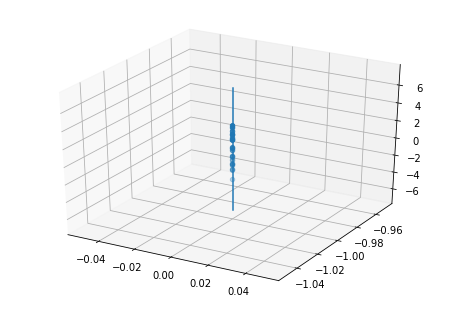

In [14]:
# Line fitting for probe

data = np.array(probe_coord)

# Calculate the mean of the points, i.e. the 'center' of the cloud
datamean = data.mean(axis=0)

# Do an SVD on the mean-centered data.
uu, dd, vv = np.linalg.svd(data - datamean)

# Now vv[0] contains the first principal component, i.e. the direction
# vector of the 'best fit' line in the least squares sense.

# Now generate some points along this best fit line, for plotting.

# I use -7, 7 since the spread of the data is roughly 14
# and we want it to have mean 0 (like the points we did
# the svd on). Also, it's a straight line, so we only need 2 points.
linepts = vv[0] * np.mgrid[-7:7:2j][:, np.newaxis]

# shift by the mean to get the line in the right place
linepts += datamean

# Verify that everything looks right.

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as m3d

ax = m3d.Axes3D(plt.figure())
ax.scatter3D(*data.T)
ax.plot3D(*linepts.T)
plt.show()

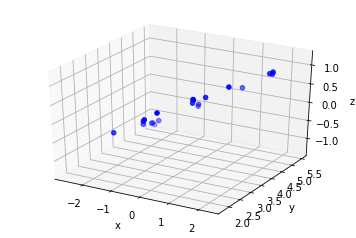

In [8]:
# TESTING
time_stamp = []
distance = []
with open('obs.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count != 0:
            time_stamp.append(row[0])
            distance.append(row[1])
        line_count+=1

probe_coord = [[0.4181154710411328, -1.1428317247359774, -0.6544772905876082], [0.5901997846785876, -1.2016171584718809, -1.0267341538982733], [-0.12038268366663414, -0.9588762733566504, 0.51041467273463], [-0.5107864128827047, -0.8255111102632159, 1.3549452670161122], [-1.038206863967899, -0.6453398946371991, 2.4958736794715817], [-0.6416527523379937, -0.7808060795506738, 1.638038432272352], [-0.43517633914360493, -0.8513401407286004, 1.1913837645766523], [0.2859426758663506, -1.0976803978764842, -0.3685579693737868], [0.8517099924241684, -1.2909512218954524, -1.5924392295171004], [1.253654624354629, -1.4282588534070055, -2.461935377912268], [0.8149188982972145, -1.2783830779423206, -1.5128518632547614], [0.2508485228875066, -1.0856919431425922, -0.29264146639738964], [-0.07766859647714384, -0.9734677610349373, 0.4180145475852969], [-0.6789320739450875, -0.7680711530269801, 1.7186819437840588], [-0.798997051771942, -0.7270559573426534, 1.9784093477207845], [-0.9526846911756395, -0.6745549806340647, 2.310870089578831], [-0.43840041543875513, -0.8502387694333217, 1.1983581627849365], [0.005532051189155672, -1.0018897947275363, 0.23803293583349058], [0.6403487190174559, -1.2187484518140188, -1.135217516505569], [0.5816171410512144, -1.1986852559784393, -1.0081679759119968]]
angle = 36*math.pi/180
points = []
v = np.array([0, math.cos(25*math.pi/180), math.sin(25*math.pi/180)])
R = np.array([[math.cos(angle), 0, math.sin(angle)],[0,1,0],[-math.sin(angle), 0, math.cos(angle)]])
    
for i in range(0,20):
    x = probe_coord[i][0] + (v[0]*float(distance[i]))
    y = probe_coord[i][1] + (v[1]*float(distance[i]))
    z = probe_coord[i][2] + (v[2]*float(distance[i]))
    points.append([x,y,z])
    v = R.dot(np.array(v))

xs = []
ys = []
zs = []
for i in points:
    xs.append(i[0])
    ys.append(i[1])
    zs.append(i[2])

plt.figure()
ax = plt.subplot(111, projection='3d')
ax.scatter(xs, ys, zs, color='b')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()